In [82]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("venktesh/person-images")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'person-images' dataset.
Path to dataset files: /kaggle/input/person-images


In [34]:
# import librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.datasets import load_files
from keras.utils import to_categorical


In [43]:
import glob
# load dog name list
dog_names = [item[58:] for item in sorted(glob.glob(path+'/dogImages/dogImages/train/*'))]

In [44]:
dog_names

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

In [45]:
# load the paths of dataset
def load_dataset(path):
  data = load_files(path)
  dog_files = np.array(data['filenames'])
  dog_targets = np.array(data['target'])
  return dog_files, dog_targets

train_files, train_targets = load_dataset(path+'/dogImages/dogImages/train')
test_files, test_targets = load_dataset(path+'/dogImages/dogImages/test')
valid_files, valid_targets = load_dataset(path+'/dogImages/dogImages/valid')

In [46]:
train_targets[1]

np.int64(56)

### Visualize first 12 images and labels

In [47]:
dog_names[56]

'Dalmatian'

In [48]:
train_files[1]

np.str_('/kaggle/input/person-images/dogImages/dogImages/train/057.Dalmatian/Dalmatian_04054.jpg')

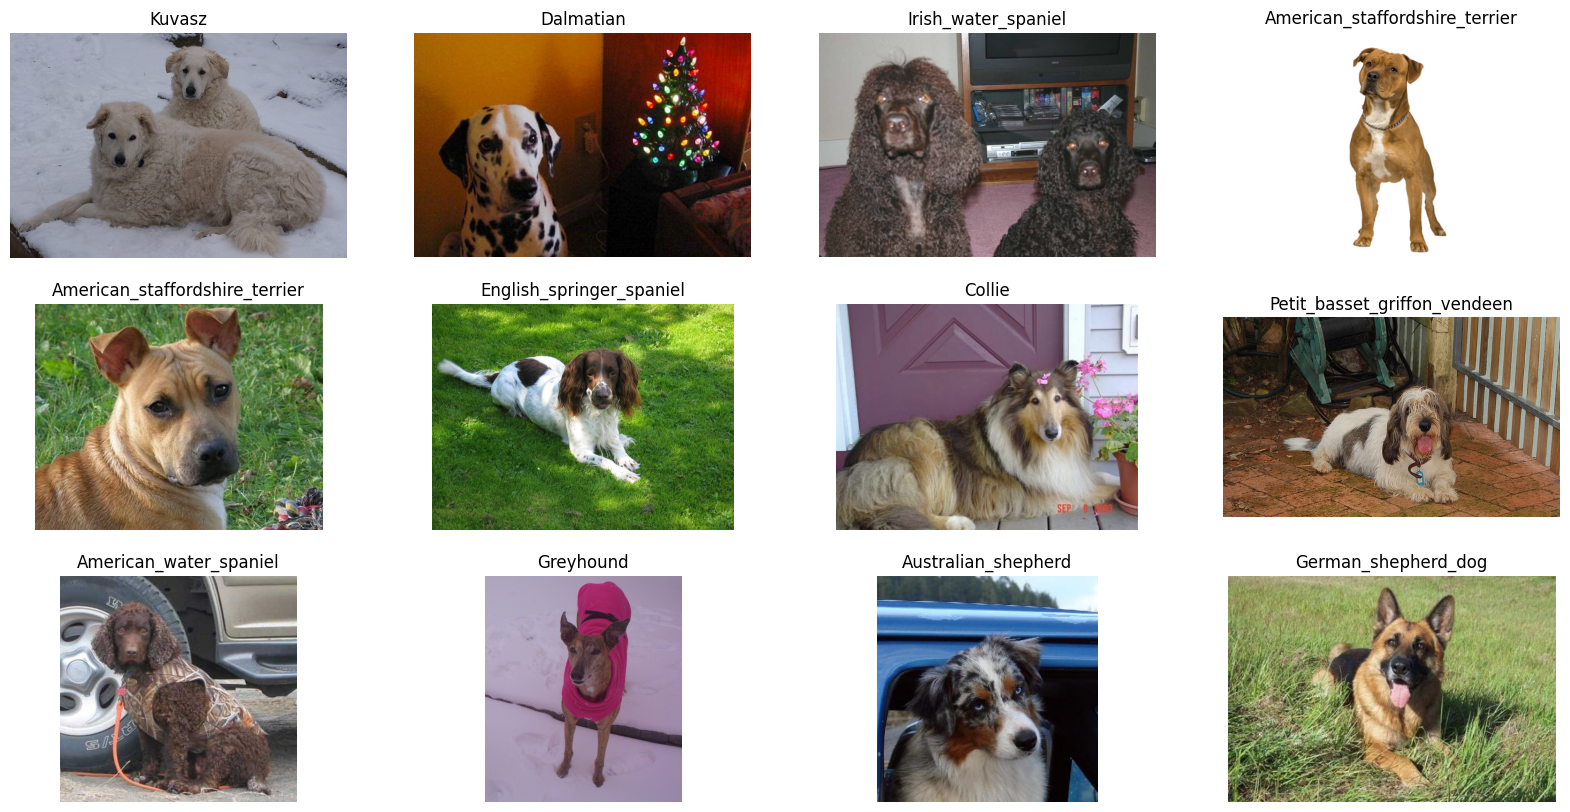

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# visualize 12 first image in train dataset
plt.figure(figsize=(20,10))
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(load_img(train_files[i]))
  plt.axis('off')
  plt.title(dog_names[train_targets[i]])
  plt.show()

## Create the CNN to classify Dog Breeds using Transfer Learning

In [61]:
import tensorflow as tf
from struct import unpack
from tqdm import tqdm
import os
# checking image decoding
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break

# function evaluate image dataset
def evaluate_images(paths, targets):
  pass_images = []
  pass_target = []

  for i,path in enumerate(tqdm(paths)):
    image = JPEG(path)
    try:
      image.decode()
    except:
      continue
    pass_images.append(path)
    pass_target.append(targets[i])
  return pass_images, pass_target


# fuction load and preprocess images of dataset
def load_and_preprocess_dataset(image_path, label):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = keras.layers.Resizing(224,224)(image)
  #image = keras.layers.Rescaling(1./255)(image)
  #image = tf.image.random_flip_left_right(image)
  return image, label

In [62]:
# prepare train dataset
image_paths, image_targets = evaluate_images(train_files, train_targets)
train_ds = tf.data.Dataset.from_tensor_slices((image_paths, image_targets))
train_ds = train_ds.map(load_and_preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
image_paths.clear(); image_targets.clear()

# prepare validation dataset
image_paths, image_targets = evaluate_images(test_files, test_targets)
test_ds = tf.data.Dataset.from_tensor_slices((image_paths, image_targets))
test_ds = test_ds.map(load_and_preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
image_paths.clear(); image_targets.clear()

# prepare validation dataset
image_paths, image_targets = evaluate_images(valid_files, valid_targets)
valid_ds = tf.data.Dataset.from_tensor_slices((image_paths, image_targets))
valid_ds = valid_ds.map(load_and_preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.shuffle(1000).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
image_paths.clear(); image_targets.clear()

100%|██████████| 835/835 [00:00<00:00, 1447.74it/s]


In [63]:
for image, label in train_ds.take(1):
  print(image.shape)
  print(label.shape)
  break

(32, 224, 224, 3)
(32,)


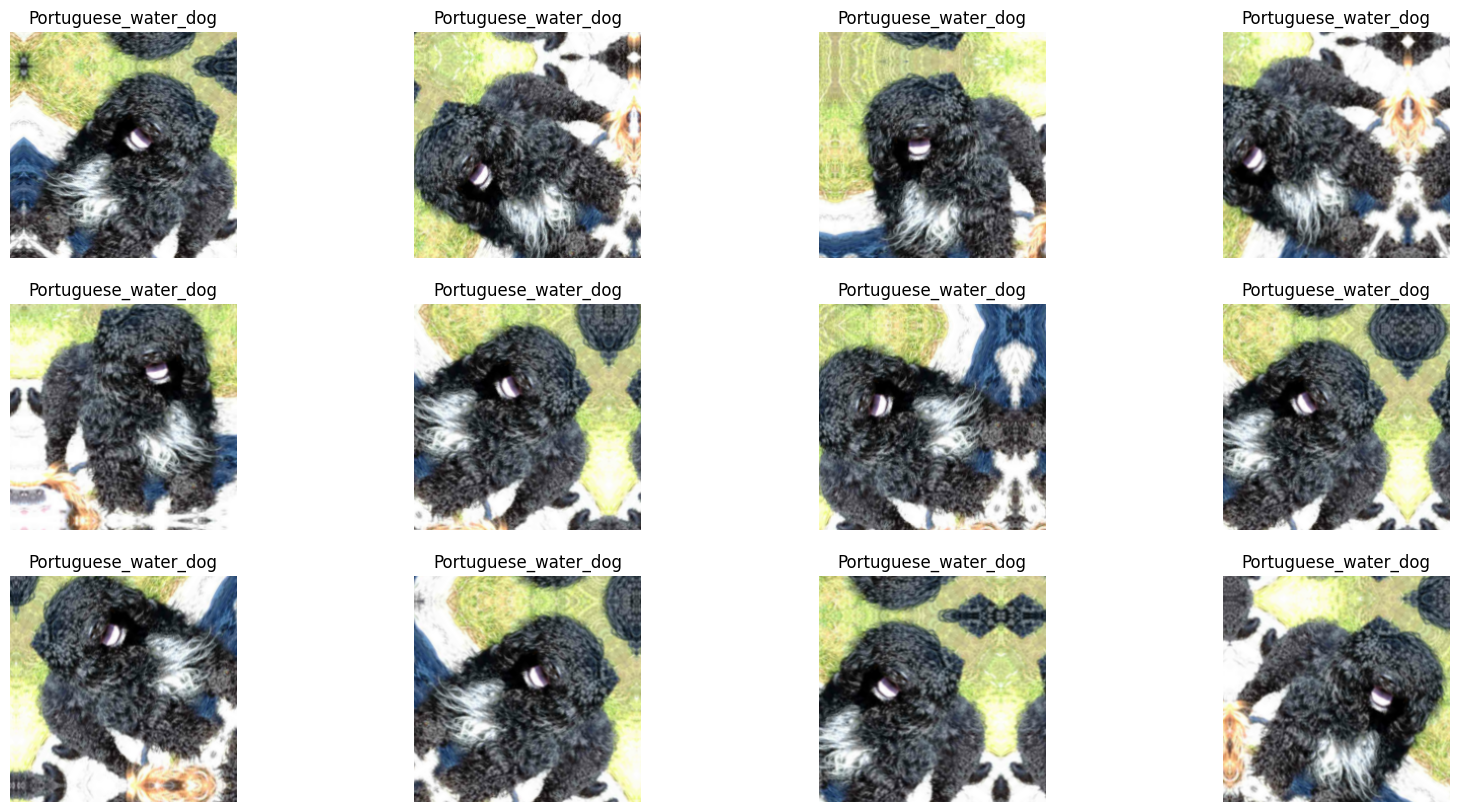

In [84]:
import keras
# function process data augmentation
data_augment = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(0.2,0.2),
])

# display a image was augment
for image, label in train_ds.take(1):
  plt.figure(figsize=(20,10))
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(data_augment(image[0]).numpy().astype("uint8"))
    plt.axis('off')
    plt.title(dog_names[label[0]])
  plt.show()
  break

In [71]:
from keras.layers import Input
# function to build a model architecture
def build_model(base_model,preprocess, test = False):
  inputs = Input(shape=(224,224,3))
  if test == False:
    # data augmentation
    x = keras.layers.RandomFlip('horizontal')(inputs)
    x = keras.layers.RandomRotation(0.2)(x)
    x = keras.layers.RandomTranslation(0.2,0.2)(x)
    x = preprocess(x)
  else:
    x = preprocess(inputs)
  x = base_model(x, training = False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(133, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [65]:
# define callback functions
def call_backs(model_name):
  check_point = keras.callbacks.ModelCheckpoint('saved_models.weights.best.'+ model_name +'.keras',monitor='val_los', save_best_only=True)
  EarlyStopping= keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  return check_point

In [ ]:
from keras.applications import ResNet50, Xception, MobileNetV2
from keras.applications import resnet50,xception, mobilenet_v2
# load pretrained model
Mobile_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
Mobile_model.trainable = False
# build model
model_Mobile = build_model(Mobile_model,mobilenet_v2.preprocess_input)

EPOCHS = 25
# train the model (vgg16)
model_Mobile.summary()
model_Mobile.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_Mobile_his = model_Mobile.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[call_backs("model_MobileV2")])

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 133)            │       170,373 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,357 (9.26 MB)

 Trainable params: 170,373 (665.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/25
208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2964 - loss: 3.2966

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_los available.
  if self._should_save_model(epoch, batch, logs, filepath):


209/209 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.2979 - loss: 3.2873 - val_accuracy: 0.7716 - val_loss: 0.8433
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.6731 - loss: 1.1469 - val_accuracy: 0.8041 - val_loss: 0.6097
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.7368 - loss: 0.9078 - val_accuracy: 0.8185 - val_loss: 0.5213
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.7616 - loss: 0.7932 - val_accuracy: 0.8329 - val_loss: 0.4905
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.7774 - loss: 0.7330 - val_accuracy: 0.8317 - val_loss: 0.4850
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.7909 - loss: 0.6903 - val_accuracy: 0.8329 - val_loss: 0.4644
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8013 - loss: 0.6244 - val_accuracy: 0.8486 - val_loss: 0.4433
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.8179 - loss: 0.6077 - val_accura

In [ ]:
ResNet50_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
ResNet50_model.trainable = False
model_ResNet50 = build_model(ResNet50_model, resnet50.preprocess_input)

# train model (resnet50)
model_ResNet50.summary()
model_ResNet50.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
EPOCHS = 25
model_ResNet50_his = model_ResNet50.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[call_backs("model_ResNet50")])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 224, 224,  │          0 │ input_layer_17[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential_8[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential_8[2][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential_8[2][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_24[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 133)       │    272,517 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,860,229 (91.02 MB)

 Trainable params: 272,517 (1.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.2393 - loss: 3.6317 - val_accuracy: 0.6815 - val_loss: 1.0565
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.6568 - loss: 1.1895 - val_accuracy: 0.7596 - val_loss: 0.7870
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.7383 - loss: 0.9021 - val_accuracy: 0.7704 - val_loss: 0.7434
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.7711 - loss: 0.7506 - val_accuracy: 0.7945 - val_loss: 0.6531
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.7978 - loss: 0.6514 - val_accuracy: 0.8029 - val_loss: 0.6545
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.8261 - loss: 0.5677 - val_accuracy: 0.7993 - val_loss: 0.6598
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.8358 - loss: 0.5243 - val_accuracy: 0.7921 - val_loss: 0.6664
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 152ms/step - accuracy: 0.8452 - loss: 0

In [ ]:
Xception_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
Xception_model.trainable = False
model_Xception = build_model(Xception_model, xception.preprocess_input)
# train model (Exception)

model_Xception.summary()
EPOCHS =25
model_Xception.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_Xception_his = model_Xception.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[call_backs("model_Xception")])

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 133)            │       272,517 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,133,997 (80.62 MB)

 Trainable params: 272,517 (1.04 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - accuracy: 0.3743 - loss: 3.0029 - val_accuracy: 0.7945 - val_loss: 0.6417
Epoch 2/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.6592 - loss: 1.1532 - val_accuracy: 0.8413 - val_loss: 0.5132
Epoch 3/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.7107 - loss: 0.9829 - val_accuracy: 0.8498 - val_loss: 0.4705
Epoch 4/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.7220 - loss: 0.8955 - val_accuracy: 0.8522 - val_loss: 0.4592
Epoch 5/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.7428 - loss: 0.8588 - val_accuracy: 0.8546 - val_loss: 0.4450
Epoch 6/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.7433 - loss: 0.8866 - val_accuracy: 0.8546 - val_loss: 0.4372
Epoch 7/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 199ms/step - accuracy: 0.7726 - loss: 0.7756 - val_accuracy: 0.8570 - val_loss: 0.4370
Epoch 8/25
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.7731 - loss: 0

In [ ]:
# evaluate best model(vgg16)
model_Mobile = build_model(Mobile_model,mobilenet_v2.preprocess_input, test = True)
model_Mobile.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ResNet50 = build_model(ResNet50_model, resnet50.preprocess_input, test = True)
model_ResNet50.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_Xception = build_model(Xception_model, xception.preprocess_input, test = True)
model_Xception.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_Mobile.load_weights('saved_models.weights.best.model_MobileV2.keras')
loss, acc = model_Mobile.evaluate(test_ds)
print('Test accuracy of model (MobileV2): ', acc *100 ,"%")
print('Test loss of model (MobileV2): ', loss)

# eveluate best model(resnet50)
model_ResNet50.load_weights('saved_models.weights.best.model_ResNet50.keras')
loss, acc = model_ResNet50.evaluate(test_ds)
print('Test accuracy of model (resnet50): ', acc *100 ,"%")
print('Test loss of model (resnet50): ', loss)

# eveluate best model(xception)
model_Xception.load_weights('saved_models.weights.best.model_Xception.keras')
loss, acc = model_Xception.evaluate(test_ds)
print('Test accuracy of model (xception): ', acc *100 ,"%")
print('Test loss of model (xception): ', loss)

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8665 - loss: 0.4564
Test accuracy of model (MobileV2):  83.65384340286255 %
Test loss of model (MobileV2):  0.5658527612686157
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8372 - loss: 0.6961
Test accuracy of model (resnet50):  81.00961446762085 %
Test loss of model (resnet50):  0.8596646785736084
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.8656 - loss: 0.4004
Test accuracy of model (xception):  85.09615659713745 %
Test loss of model (xception):  0.5244393944740295


## Plot trainning history (accuracy, loss) of each model by epochs

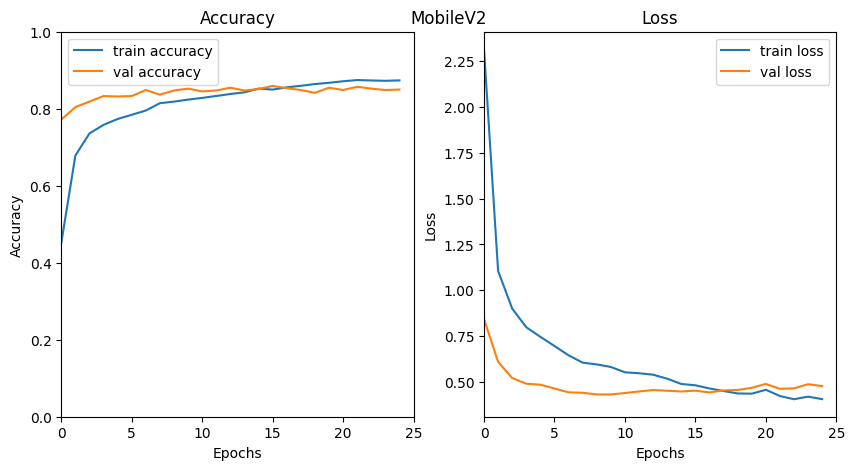

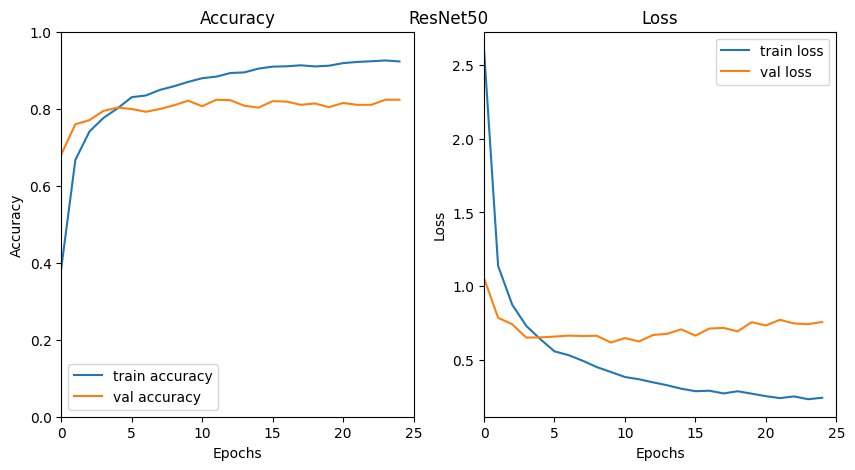

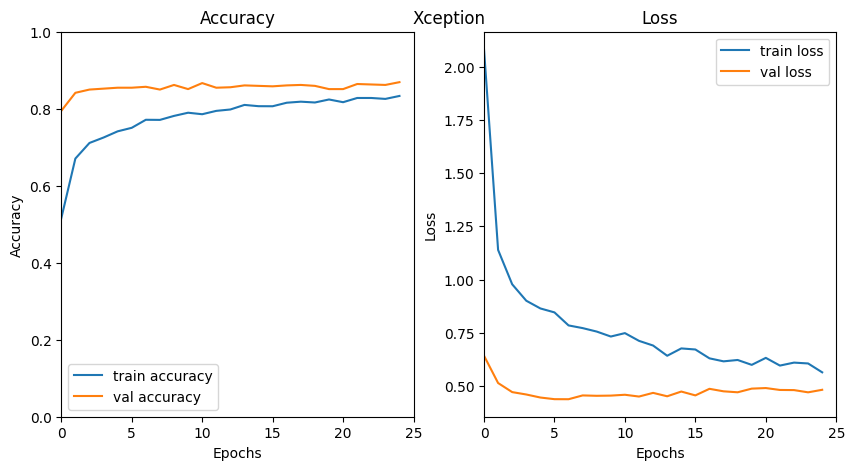

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot accuracy and loss by epoch of models
# graph of VGG16
fig1 = plt.figure(figsize=(10,5))
plt.title("MobileV2")
plt.axis('off')
ax1 = fig1.add_subplot(121)
ax1.plot(model_Mobile_his.history['accuracy'], label='train accuracy')
ax1.plot(model_Mobile_his.history['val_accuracy'], label='val accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
ax1.set_ylim(0,1)
ax1.set_xlim(0,EPOCHS)
ax1.legend()

ax2 = fig1.add_subplot(122)
ax2.plot(model_Mobile_his.history['loss'], label='train loss')
ax2.plot(model_Mobile_his.history['val_loss'], label='val loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.set_xlim(0,EPOCHS)
ax2.legend()
plt.show()

# graph of ResNet50
fig2 = plt.figure(figsize=(10,5))
plt.title("ResNet50")
plt.axis('off')
ax3 = fig2.add_subplot(121)
ax3.plot(model_ResNet50_his.history['accuracy'], label='train accuracy')
ax3.plot(model_ResNet50_his.history['val_accuracy'], label='val accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy')
ax3.set_xlim(0,EPOCHS)
ax3.set_ylim(0,1)
ax3.legend()

ax4 = fig2.add_subplot(122)
ax4.plot(model_ResNet50_his.history['loss'], label='train loss')
ax4.plot(model_ResNet50_his.history['val_loss'], label='val loss')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.set_title('Loss')
ax4.set_xlim(0,EPOCHS)
ax4.legend()
plt.show()

# graph of Exception
fig3 = plt.figure(figsize=(10,5))
plt.title("Xception")
plt.axis('off')
ax5 = fig3.add_subplot(121)
ax5.plot(model_Xception_his.history['accuracy'], label='train accuracy')
ax5.plot(model_Xception_his.history['val_accuracy'], label='val accuracy')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('Accuracy')
ax5.set_title('Accuracy')
ax5.set_xlim(0,EPOCHS)
ax5.set_ylim(0,1)
ax5.legend()

ax6 = fig3.add_subplot(122)
ax6.plot(model_Xception_his.history['loss'], label='train loss')
ax6.plot(model_Xception_his.history['val_loss'], label='val loss')
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Loss')
ax6.set_title('Loss')
ax6.set_xlim(0,EPOCHS)
ax6.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# function to get predictions and true labels from a dataset
def get_predictions_and_labels(model, dataset):
  all_predictions = []
  all_labels = []
  for images, labels in dataset:
    predictions = model.predict(images)
    all_predictions.append(predictions)
    all_labels.append(labels.numpy())
  all_predictions = np.concatenate(all_predictions, axis=0)
  all_labels = np.concatenate(all_labels, axis=0)
  return all_predictions, all_labels

# model classification report
model_Mobile.load_weights('saved_models.weights.best.model_MobileV2.keras')
y_pred_mobilev2, y_true_mobilev2 = get_predictions_and_labels(model_Mobile, test_ds)
print("classification report MobileV2:\n",classification_report(y_true_mobilev2, np.argmax(y_pred_mobilev2, axis=1)))

model_ResNet50.load_weights('saved_models.weights.best.model_ResNet50.keras')
y_pred_resnet50, y_true_resnet50 = get_predictions_and_labels(model_ResNet50, test_ds)
print("classification report ResNet50:\n" ,classification_report(y_true_resnet50, np.argmax(y_pred_resnet50, axis=1)))

model_Xception.load_weights('saved_models.weights.best.model_Xception.keras')
y_pred_xception, y_true_xception = get_predictions_and_labels(model_Xception, test_ds)
print("classification report Xception:\n" ,classification_report(y_true_xception, np.argmax(y_pred_xception, axis=1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
classification report MobileV2:
               pre

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Optimizer the best Model

model_Xception:
*   well perform, the validation accuracy highest among three models (~86%)
*   the validation loss is lowest and stable
*   the gap between training curve and validation curve is small -> model not over fitting.
-> best overall

model_MobileV2:
*   perform well close to Xception model.( just slightly lower)
*   slightly overfitting.
*   ligthweight model -> fast references.
-> good alternative if the speed or efficient are requirement.

model_ResNet50:
*   validation and training curve stay far -> overfitting.
*   validation loss is flatten early then slightly rises.
*   validation accuracy highest among three models.
-> the model not perform very well. The model maybe is too large, so it lead to overfitting easily then the rest. Beside the dataset of this task is limited (small dataset). Finall, the trainning set up not fine-tune it well

-> model Xception is best option for optimizer.

Techiques:  

1.   data augmentation(the previous data aurmentation function is sufficient good for xception, so not need it)
2.   lower learning rate
3.   unfreeze base layer for fine-tune

In [72]:
from keras.applications import Xception, xception
# load pretrained model
Xception_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
Xception_model.trainable = False
# optimizer the model by lower learning rate
model_x = build_model(Xception_model, xception.preprocess_input)
model_x.load_weights('saved_models.weights.best.model_Xception.keras')
model_x.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 1e-5) , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
his = model_x.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[call_backs("model_X_optimizer")])

Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8455 - loss: 0.5457

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_los available.
  if self._should_save_model(epoch, batch, logs, filepath):


209/209 ━━━━━━━━━━━━━━━━━━━━ 66s 244ms/step - accuracy: 0.8455 - loss: 0.5457 - val_accuracy: 0.8678 - val_loss: 0.4788
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.8422 - loss: 0.5314 - val_accuracy: 0.8690 - val_loss: 0.4767
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 199ms/step - accuracy: 0.8461 - loss: 0.5154 - val_accuracy: 0.8666 - val_loss: 0.4764
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.8609 - loss: 0.4821 - val_accuracy: 0.8666 - val_loss: 0.4758
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.8534 - loss: 0.4963 - val_accuracy: 0.8666 - val_loss: 0.4755
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.8464 - loss: 0.5092 - val_accuracy: 0.8666 - val_loss: 0.4751
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.8427 - loss: 0.5413 - val_accuracy: 0.8666 - val_loss: 0.4751
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 44s 212ms/step - accuracy: 0.8492 - loss: 0.5092 - val

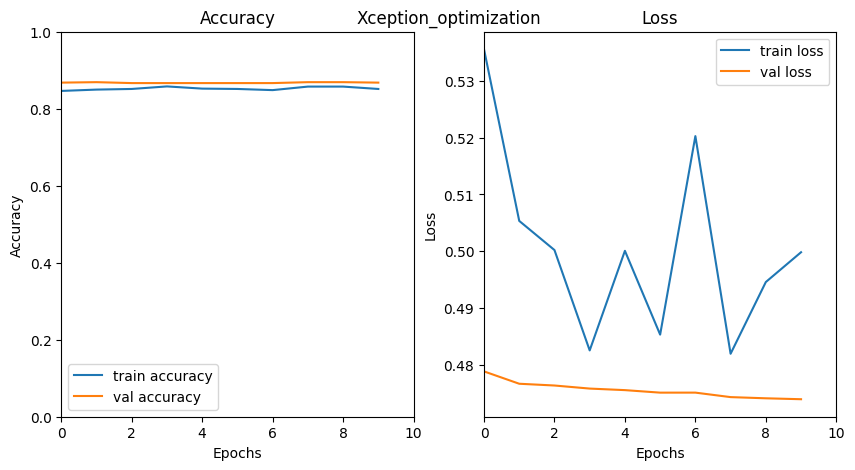

In [75]:
# graph of learning curve after optimizer with learning rate
fig = plt.figure(figsize=(10,5))
plt.title("Xception_optimization")
plt.axis('off')
ax = fig.add_subplot(121)
ax.plot(his.history['accuracy'], label='train accuracy')
ax.plot(his.history['val_accuracy'], label='val accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.set_xlim(0,10)
ax.set_ylim(0,1)
ax.legend()

ax1 = fig.add_subplot(122)
ax1.plot(his.history['loss'], label='train loss')
ax1.plot(his.history['val_loss'], label='val loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.set_xlim(0,10)
ax1.legend()
plt.show()

In [76]:
# unfreezen all parameter of base model and retrain
Xception_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
Xception_model.trainable = True
# optimizer the model by lower learning rate
model_x = build_model(Xception_model, xception.preprocess_input)
model_x.load_weights('saved_models.weights.best.model_Xception.keras')
model_x.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 1e-5) , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
his = model_x.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[call_backs("model_X_optimizer")])


Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6813 - loss: 1.1796

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_los available.
  if self._should_save_model(epoch, batch, logs, filepath):


209/209 ━━━━━━━━━━━━━━━━━━━━ 175s 732ms/step - accuracy: 0.6816 - loss: 1.1786 - val_accuracy: 0.8245 - val_loss: 0.5539
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 151s 721ms/step - accuracy: 0.7928 - loss: 0.6825 - val_accuracy: 0.8221 - val_loss: 0.5327
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 151s 721ms/step - accuracy: 0.8229 - loss: 0.5712 - val_accuracy: 0.8293 - val_loss: 0.5093
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 151s 722ms/step - accuracy: 0.8398 - loss: 0.4977 - val_accuracy: 0.8257 - val_loss: 0.5013
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 151s 721ms/step - accuracy: 0.8626 - loss: 0.4465 - val_accuracy: 0.8341 - val_loss: 0.4881
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 151s 722ms/step - accuracy: 0.8685 - loss: 0.4037 - val_accuracy: 0.8365 - val_loss: 0.4884
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 150s 720ms/step - accuracy: 0.8846 - loss: 0.3871 - val_accuracy: 0.8401 - val_loss: 0.4773
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 151s 721ms/step - accuracy: 0.8874 - loss: 0.36

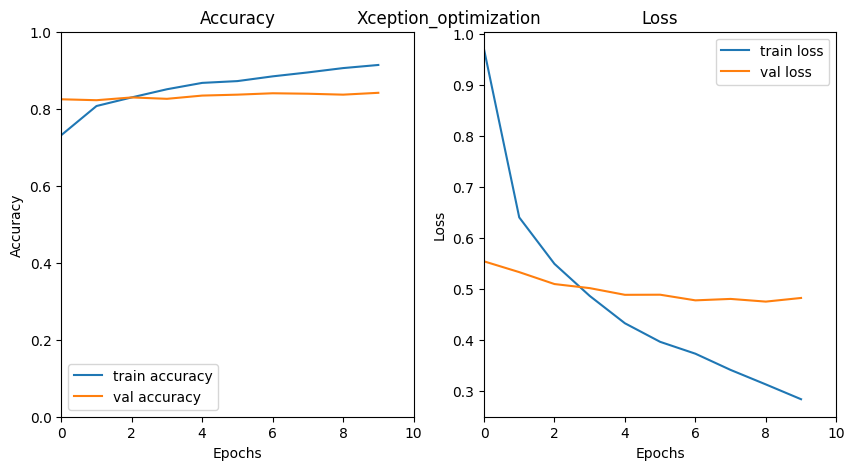

In [77]:
# graph of learning curve after optimizer with learning rate
fig = plt.figure(figsize=(10,5))
plt.title("Xception_optimization")
plt.axis('off')
ax = fig.add_subplot(121)
ax.plot(his.history['accuracy'], label='train accuracy')
ax.plot(his.history['val_accuracy'], label='val accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.set_xlim(0,10)
ax.set_ylim(0,1)
ax.legend()

ax1 = fig.add_subplot(122)
ax1.plot(his.history['loss'], label='train loss')
ax1.plot(his.history['val_loss'], label='val loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.set_xlim(0,10)
ax1.legend()
plt.show()

In [81]:
model_x.load_weights('saved_models.weights.best.model_X_optimizer.keras')
loss, acc = model_x.evaluate(test_ds)
print('Test accuracy of model (xception): ', acc *100 ,"%")
print('Test loss of model (xception): ', loss)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8587 - loss: 0.4689
Test accuracy of model (xception):  85.4567289352417 %
Test loss of model (xception):  0.4833696186542511


The result of valuation test datasets of the Xception model before optimization:

*   Test accuracy:  85.096 %
*   Test loss:  0.524

After fine-tune:
*   Test accuracy:  85.457 %
*   Test loss:  0.483

the final model after fine-tune is slightly imporvement. after epoch 4, the model doesn't improve much, but start over fitting. Thus, this is final model, it can not to optimite any more.